# Importing Lib



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
data = pd.read_csv('/content/ALL_FAIL_LOG_GPS_0_Add_Num_Random.csv')


# Preprocessing and Exploring data



In [ ]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (4319, 17)

Columns:
 Index(['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U', 'labels'],
      dtype='object')

Sample Data:
    LineNo     TimeUS  I  Status        GMS   GWk  NSats  HDop        Lat  \
0  186120  238603687  0       6  547888600  2232     10  1.21 -35.360988   
1   70202  109203801  0       1  547759200  2232      3  1.21 -35.362661   
2   37211   72603447  0       6  547722600  2232     10  1.21 -35.363286   
3  426537  505803431  0       6  548155800  2232     10  1.21 -35.363284   
4  319397  386803550  0       6  548036800  2232     10  1.21 -35.361890   

          Lng    Alt    Spd       GCrs     VZ  Yaw  U  labels  
0  149.163326  48.64  1.700   29.63562 -1.197    0  1       0  
1  149.162593  39.94  3.885  327.20960  0.031    0  1       1  
2  149.163059  39.94  0.025  303.80130 -0.009    0  1       0  
3  149.163061  20.39  0.000  258.62220  0.000    0  1       4  
4  1

In [ ]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo      int64
TimeUS      int64
I           int64
Status      int64
GMS         int64
GWk         int64
NSats       int64
HDop      float64
Lat       float64
Lng       float64
Alt       float64
Spd       float64
GCrs      float64
VZ        float64
Yaw         int64
U           int64
labels      int64
dtype: object


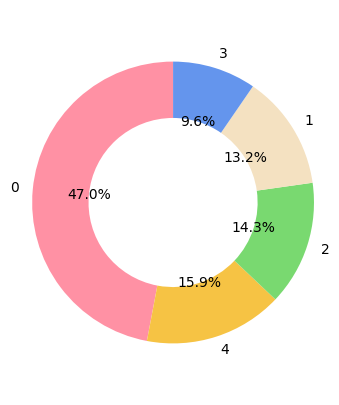

In [ ]:

if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    # Define specific colors for 5 labels
    colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

    # Plot the donut chart
    plt.figure(figsize=(4, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': 0.4})
    plt.axis('equal')
    plt.show()



In [ ]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [ ]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [ ]:
X.shape

(4319, 16)

In [ ]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [ ]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [ ]:
X_reshaped.shape

(4319, 1, 16)

# Model

In [ ]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [ ]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [ ]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    # inputs = Input(shape=input_shape)
# def build_tcn_attention_model(X_reshaped, num_classes):
    inputs = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
     # Replacing input_shape with X_reshaped.shape
    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model


In [ ]:
# input_shape
X_reshaped.shape[2]

16

In [ ]:
X_reshaped.shape[1]

1

In [ ]:
X_reshaped.shape[0]

4319

In [ ]:
X_train_foldKF.shape

NameError: name 'X_train_foldKF' is not defined

In [ ]:
X_reshaped.shape

(4319, 1, 16)

In [ ]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [ ]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuraciesKF = []
label_accuraciesKF = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_foldKF, X_val_foldKF = X_reshaped[train_index], X_reshaped[val_index]
    y_train_foldKF, y_val_foldKF = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    # modelKF = build_tcn_attention_model(input_shape, num_classes)
    modelKF = build_tcn_attention_model(X_reshaped, num_classes)
    modelKF.fit(X_train_foldKF, y_train_foldKF, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_foldKF, y_val_foldKF))

    # Evaluate the model
    lossKF, accuracyKF = modelKF.evaluate(X_val_foldKF, y_val_foldKF, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracyKF:.4f}")
    accuraciesKF.append(accuracyKF)

    # Predictions
    y_predKF = modelKF.predict(X_val_foldKF)
    y_pred_classesKF = np.argmax(y_predKF, axis=1)
    y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

    # Accuracy per label
    label_accKF = []
    for label in range(num_classes):
        label_indicesKF = (y_true_classesKF == label)
        label_accKF.append(accuracy_score(y_true_classesKF[label_indicesKF], y_pred_classesKF[label_indicesKF]))
    label_accuraciesKF.append(label_accKF)

    fold_no += 1




Training fold 1...
Validation Accuracy for fold 1: 0.9884
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   

Training fold 2...
Validation Accuracy for fold 2: 0.9919
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   

Training fold 3...
Validation Accuracy for fold 3: 0.9826
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

Training fold 4...
Validation Accuracy for fold 4: 0.9815
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

Training fold 5...
Validation Accuracy for fold 5: 0.9745
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
modelKF.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 1, 64)               │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,705 (385.57 KB)

 Trainable params: 32,773 (128.02 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 65,548 (256.05 KB)

In [ ]:
# Calculate average accuracy
average_accuracyKF = np.mean(accuraciesKF)
print(f"\nAverage Accuracy across all folds: {average_accuracyKF:.4f}")


Average Accuracy across all folds: 0.9838


In [ ]:
# Average accuracy per label
label_accuraciesKF = np.mean(label_accuraciesKF, axis=0)
for idx, acc in enumerate(label_accuraciesKF):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9867
Label 1 Accuracy: 0.9877
Label 2 Accuracy: 0.9774
Label 3 Accuracy: 0.9749
Label 4 Accuracy: 0.9827


In [ ]:
# Evaluate the last fold predictions
y_predKF = modelKF.predict(X_val_foldKF)
y_pred_classesKF = np.argmax(y_predKF, axis=1)
y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
import pandas as pd
import numpy as np

feature_names = ["DesRoll", "Roll", "DesPitch", "Pitch", "DesYaw", "Yaw", "ErrRP", "ErrYaw",
                 "MagX", "MagY", "MagZ", "abGyrX", "abGyrY", "abGyrZ", "abAccX", "abAccY"]


# Step 1: Get Model Predictions
y_pred_probs = modelKF.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Filter only misclassified samples
mismatch_indices = y_true_labels != y_pred_labels  # Boolean mask for incorrect predictions

# Step 3: Print only misclassified rows
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]))  # Flatten features
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

print(df_mismatches)  # Print all misclassified cases




135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           0         1    2         3         4         5         6    7  \
0   0.286002  0.197539  0.0  0.383595  0.873475 -0.873417  0.383595  0.0   
1  -0.167221 -0.258144  0.0  0.383595  0.873208 -0.873417  0.383595  0.0   
2  -1.100502 -1.200202  0.0 -2.606919  0.872656 -0.873417 -2.606919  0.0   
3  -1.098974 -1.198668  0.0 -2.606919  0.872657 -0.873417 -2.606919  0.0   
4   0.391297  0.303408  0.0  0.383595  0.873537 -0.873417  0.383595  0.0   
5   0.756580  0.670105  0.0  0.383595  0.873752 -0.873417  0.383595  0.0   
6   0.231089  0.142307  0.0  0.383595  0.873443 -0.873417  0.383595  0.0   
7   1.491049  1.408100  0.0  0.383595  0.874185 -0.873417  0.383595  0.0   
8   0.394352  0.306475  0.0  0.383595  0.873539 -0.873417  0.383595  0.0   
9   1.488002  1.405033  0.0  0.383595  0.874183 -0.873417  0.383595  0.0   
10  1.489530  1.406567  0.0  0.383595  0.874184 -0.873417  0.383595  0.0   
11  0.392833  0.304942  0.0  0.383595  0.873538

In [ ]:
import pandas as pd
import numpy as np

feature_names = ["DesRoll", "Roll", "DesPitch", "Pitch", "DesYaw", "Yaw", "ErrRP", "ErrYaw",
                 "MagX", "MagY", "MagZ", "abGyrX", "abGyrY", "abGyrZ", "abAccX", "abAccY"]

# Step 1: Get Model Predictions
y_pred_probs = modelKF.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Identify misclassified samples and their indices
mismatch_indices = np.where(y_true_labels != y_pred_labels)[0]  # Get actual indices

# Step 3: Create DataFrame of misclassified samples with indices
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_mismatches['Index'] = mismatch_indices  # Add original index
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

# Print misclassified samples with their original indices
print(df_mismatches[['Index', 'Actual_Label', 'Predicted_Label'] + feature_names])


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
    Index  Actual_Label  Predicted_Label   DesRoll      Roll  DesPitch  \
0     242             2                0  0.286002  0.197539       0.0   
1     592             0                2 -0.167221 -0.258144       0.0   
2     808             0                1 -1.100502 -1.200202       0.0   
3     852             0                1 -1.098974 -1.198668       0.0   
4     991             0                2  0.391297  0.303408       0.0   
5    1079             3                0  0.756580  0.670105       0.0   
6    1332             2                0  0.231089  0.142307       0.0   
7    1555             4                0  1.491049  1.408100       0.0   
8    1579             0                2  0.394352  0.306475       0.0   
9    1702             4                0  1.488002  1.405033       0.0   
10   1725             4                0  1.489530  1.406567       0.0   
11   1812             0                2  0.392833  0.304942       0.0 

In [ ]:
# Step 1: Identify correctly classified indices
correct_indices = np.where(y_true_labels == y_pred_labels)[0]

# Step 2: Create DataFrame of correctly classified samples
df_correct = pd.DataFrame(X_reshaped[correct_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_correct['Index'] = correct_indices  # Add original index
df_correct['Actual_Label'] = y_true_labels[correct_indices]
df_correct['Predicted_Label'] = y_pred_labels[correct_indices]

# Step 3: Save to CSV
df_correct.to_csv("correctly_classified.csv", index=False)

# Print first few rows
print(df_correct.head())


    DesRoll      Roll  DesPitch     Pitch    DesYaw       Yaw     ErrRP  \
0 -0.098467 -0.189102       0.0  0.383595  0.873249 -0.873417  0.383595   
1 -1.082155 -1.181791       0.0 -2.606919  0.872667 -0.873417 -2.606919   
2 -1.362119 -1.462570       0.0  0.383595  0.872502 -0.873417  0.383595   
3  1.941727  1.860716       0.0  0.383595  0.874450 -0.873417  0.383595   
4  1.032530  0.947810       0.0  0.383595  0.873915 -0.873417  0.383595   

   ErrYaw      MagX      MagY      MagZ    abGyrX    abGyrY    abGyrZ  abAccX  \
0     0.0  0.930327 -0.227497  1.685773 -0.516944 -1.398557 -1.354506     0.0   
1     0.0 -0.437788 -0.756066  0.601611  0.051868  1.322238  0.035754     0.0   
2     0.0 -0.948899 -0.419933  0.601611 -0.952989  1.108210 -0.009531     0.0   
3     0.0 -0.946774 -0.418419 -1.834639 -0.959497  0.695126  0.000658     0.0   
4     0.0  0.192191  1.487125 -2.068917 -0.959497  1.407962  0.000658     0.0   

   abAccY  Index  Actual_Label  Predicted_Label  
0     0.0   

In [ ]:
df_mismatches.to_csv("misclassified_samples.csv", index=False)
print("CSV file 'misclassified_samples.csv' saved successfully!")


CSV file 'misclassified_samples.csv' saved successfully!


In [ ]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classesKF, y_pred_classesKF,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9660    0.9803    0.9731       406
           1     0.9910    0.9821    0.9865       112
           2     0.9927    0.9577    0.9749       142
           3     0.9200    0.9583    0.9388        72
           4     1.0000    0.9771    0.9884       131

    accuracy                         0.9745       863
   macro avg     0.9739    0.9711    0.9724       863
weighted avg     0.9750    0.9745    0.9746       863



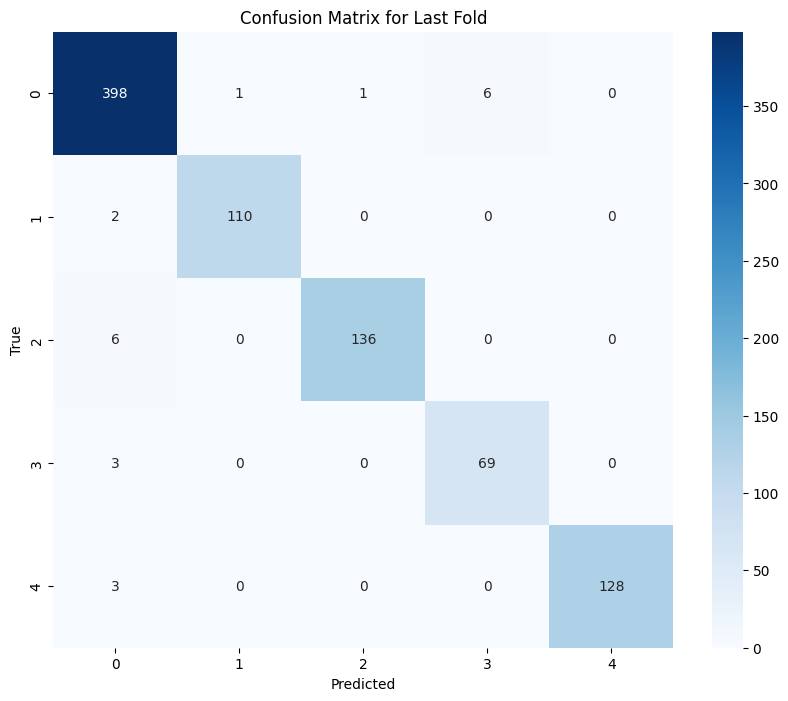

In [ ]:
# Confusion Matrix
conf_matrixKF = tf.math.confusion_matrix(y_true_classesKF, y_pred_classesKF)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrixKF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for Last Fold')
plt.show()


Label Distribution:
 labels
0    2031
4     687
2     618
1     569
3     414
Name: count, dtype: int64


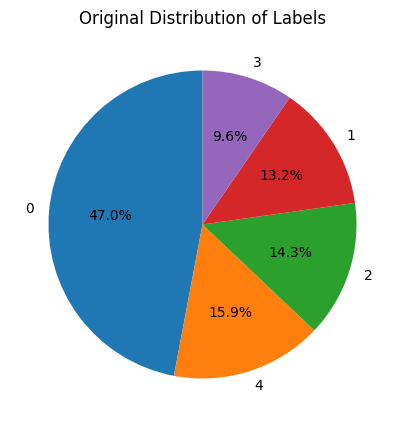

In [ ]:
if 'labels' in data.columns:
    label_countsKF = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_countsKF)
    plt.figure(figsize=(5, 5))
    plt.pie(label_countsKF, labels=label_countsKF.index, autopct='%1.1f%%', startangle=90)
    plt.title('Original Distribution of Labels')
    plt.show()

0    412
2    137
4    128
1    111
3     75
Name: count, dtype: int64


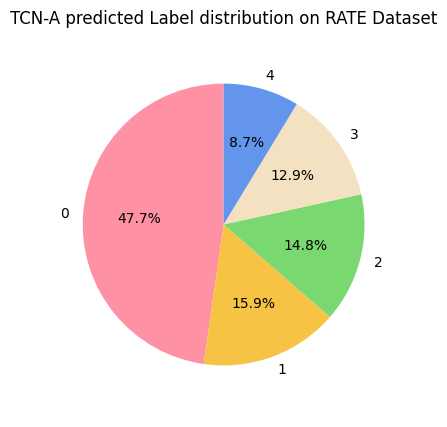

In [ ]:
# Get the label distribution after training
# Get the predicted labels after training
class_counts = pd.Series(y_pred_classesKF).value_counts()
print(class_counts)
# Plot pie chart of predicted labels
plt.figure(figsize=(4, 5))
colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]
plt.pie(pd.Series(y_pred_classesKF).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90,colors=colors)
plt.axis('equal')
plt.title('TCN-A predicted Label distribution on RATE Dataset')
plt.show()

# SHAP (According to Ma'am)

In [ ]:
import shap
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Flatten data for clustering (keeping shape (4319, 16))
X_flat = X_reshaped.reshape(X_reshaped.shape[0], -1)  # (4319, 16)

# Step 2: Apply KMeans clustering to select representative background data
num_clusters = 20  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_flat)

# Step 3: Select cluster centers as background data
background_data_kmeans = kmeans.cluster_centers_

# Step 4: Define SHAP KernelExplainer (Model-Agnostic)
def model_predict(X):
    X_input = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape back to (N, 1, 16) for TCN
    return modelKF.predict(X_input)

# Step 5: Create KernelExplainer
explainer_kernel = shap.KernelExplainer(model_predict, background_data_kmeans)

# Step 6: Compute SHAP values on a test subset
X_test_sample = X_flat[:200]  # Selecting a subset for SHAP analysis
shap_values_kernel = explainer_kernel.shap_values(X_test_sample,silent=True)

# Step 7: Visualize SHAP summary plot
# shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
X_flat.shape

(4319, 16)

In [ ]:
shap_values_kernel.shape

(200, 16, 5)

In [ ]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 0  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [0.0, 0.01104861953373662, -0.005824478529901644, -0.0011761177870522226, -0.025719195382088934]
Feature 1: [0.044534435792112845, 0.0, 0.012035147052532804, -0.001758297916913045, -0.05641252005743816]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [0.03410800683110161, -0.02532687187611963, 0.0, 0.0, -0.0007188908872083042]
Feature 4: [0.0, -0.003503149203377319, -0.018270437501043485, 0.005375495377943049, 0.0009306432126940933]
Feature 5: [-0.09130151924899296, -0.01044629293979846, 0.10633744869120638, 0.0, -0.0006177835383790658]
Feature 6: [0.07140666593018463, -0.06806572006858584, 0.0, -0.0005917412910745184, 0.0]
Feature 7: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 8: [0.049936923074060134, -0.00532300964267495, 0.012402579026169066, -0.009036039481192151, -0.04395381413990882]
Feature 9: [0.06442180526389572, -0.013717954668288825, -0.05874553204940168, -0.03700811568660679, 0.04971556079611408]
Feature 10: [-0.06042579590486985, -0.

In [ ]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 101  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the 101th data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the 101th data point:
Feature 0: [-0.06703351730994278, -0.015929964657209486, -0.18224648818760356, 0.13898619830126357, 0.12469667481553383]
Feature 1: [-0.03822239431261374, 0.0, -0.07543128124568066, 0.05518971339525127, 0.056942039288986945]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [0.00839062501477024, -0.025917626630048096, 0.015620144164985583, -0.014640592395975963, 0.015017251875770845]
Feature 4: [0.0, -0.006078172276870211, -0.03249294698068353, 0.03982733359539719, 0.0]
Feature 5: [0.01429034137205888, -0.006153088803404642, 0.0, 0.0057845945415111455, -0.004262175092128229]
Feature 6: [0.028047241127689016, -0.04325438429209693, 0.01970468962966979, -0.013628169343601027, 0.007400694055291622]
Feature 7: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 8: [0.004534360991044206, 0.005822187204551771, 0.022849701358399328, -0.03477181609987425, 0.0]
Feature 9: [-0.1741704073337922, -0.05597072263660607, 0.2092617296161464, 0.3629330982878275, -0.3438239968047676]
Fe

In [ ]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 199  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the 199th data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the 199th data point:
Feature 0: [0.13841247289440636, -0.003567798282614304, 0.06445422866785785, -0.04398460318407958, -0.1577007095410822]
Feature 1: [0.18371570153931177, -0.01041916739546324, 0.04612192854111746, -0.07740443055920322, -0.14423302678833544]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [0.014172322283768413, -0.018058349372173845, 0.0, 0.0, 0.0]
Feature 4: [0.0, -0.004753856250916667, 0.0, 0.011082019833657072, 0.005800239622012106]
Feature 5: [0.0, -0.0070375921654410815, 0.023903248370081225, 0.0, -0.008608875891205849]
Feature 6: [0.08970985712223147, -0.052854710271051444, 0.0028899128715001443, -0.03873689716804073, -0.0028890487717958876]
Feature 7: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 8: [0.08835985359609377, -0.05285412925959776, -0.11105534581887669, 0.03944830172348451, 0.033931532671298725]
Feature 9: [0.14390866322860402, -0.008230070116506503, -0.151751927501841, -0.08861287759624548, 0.1022789473396562]
Feature 10: [-0.11319840983659236

In [ ]:
import numpy as np
import pandas as pd

# Compute mean absolute SHAP values per feature for each class
shap_importance_per_class = np.mean(np.abs(shap_values_kernel), axis=0)  # Shape: (16, 5)

# Convert to DataFrame for better readability
shap_df = pd.DataFrame(shap_importance_per_class, columns=['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly'], index=feature_names)

# Display top contributing features for each anomaly type
for anomaly_class in shap_df.columns[1:]:  # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df[anomaly_class].sort_values(ascending=False))



Top Contributing Features for GPS Anomaly:
ErrRP       0.099460
MagY        0.042182
Pitch       0.041276
MagX        0.032401
abGyrX      0.021307
abGyrY      0.015950
MagZ        0.010737
DesRoll     0.010673
Yaw         0.006034
Roll        0.004028
abGyrZ      0.003258
DesYaw      0.002082
ErrYaw      0.000000
DesPitch    0.000000
abAccX      0.000000
abAccY      0.000000
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
MagY        0.204451
DesRoll     0.087063
MagX        0.081347
abGyrX      0.051552
Roll        0.044010
abGyrY      0.033404
Yaw         0.027648
MagZ        0.025701
ErrRP       0.022891
DesYaw      0.013314
Pitch       0.009794
abGyrZ      0.009740
ErrYaw      0.000000
DesPitch    0.000000
abAccX      0.000000
abAccY      0.000000
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
MagY        0.124201
MagZ        0.085254
DesRoll     0.036656
abGyrX      0.036111
abGyrZ      0.033582


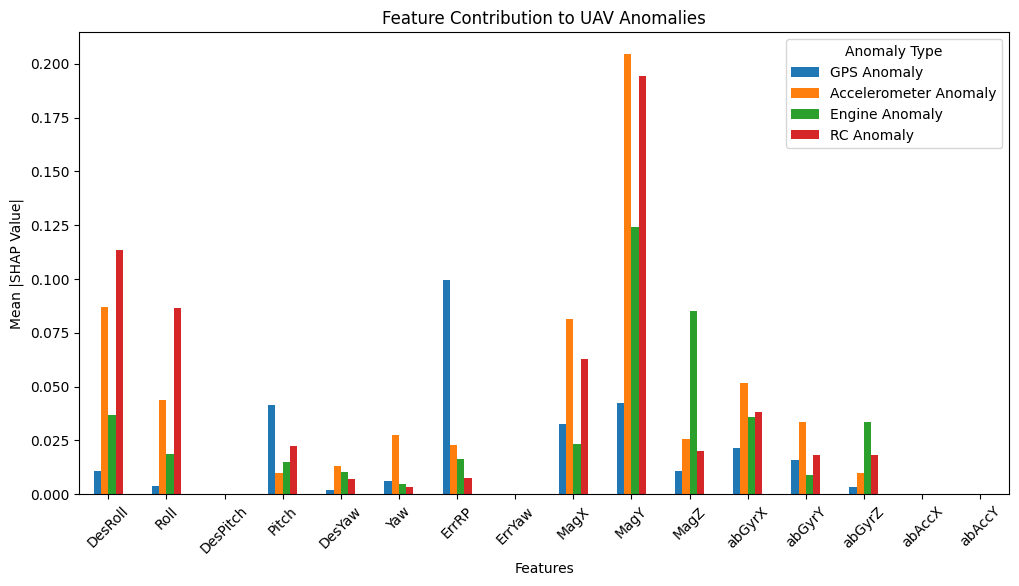

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance for each anomaly type
shap_df.iloc[:, 1:].plot(kind='bar', figsize=(12, 6), title="Feature Contribution to UAV Anomalies")
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
plt.legend(title="Anomaly Type")
plt.xticks(rotation=45)
plt.show()


In [ ]:
top_features = shap_df.iloc[:, 1:].idxmax()
print("\nMost Contributing Feature for Each Anomaly Type:\n")
print(top_features)



Most Contributing Feature for Each Anomaly Type:

GPS Anomaly              ErrRP
Accelerometer Anomaly     MagY
Engine Anomaly            MagY
RC Anomaly                MagY
dtype: object


# groups



In [ ]:
X_val_foldKF.shape

(863, 1, 16)

In [ ]:
y_pred_classesKF.shape

(863,)

In [ ]:
y_pred_classesKF

array([3, 4, 0, 1, 0, 0, 1, 4, 0, 2, 0, 3, 0, 4, 0, 4, 0, 0, 1, 1, 4, 2,
       2, 1, 3, 1, 2, 0, 0, 0, 0, 0, 1, 4, 0, 4, 2, 1, 2, 0, 2, 0, 0, 4,
       2, 0, 0, 0, 2, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 4, 2, 4, 1, 1, 0, 0, 0, 3, 1, 4, 1, 0, 4, 4,
       2, 4, 1, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 4,
       4, 1, 1, 0, 0, 0, 2, 0, 0, 0, 4, 4, 0, 0, 3, 0, 0, 2, 0, 3, 0, 2,
       0, 2, 3, 4, 1, 1, 4, 4, 0, 3, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 4, 0, 1, 2, 3, 0, 2, 2, 0, 0, 0, 0, 0, 4, 4, 3,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 4, 2, 0, 0, 0, 0, 0, 1,
       1, 3, 0, 4, 1, 4, 0, 0, 1, 1, 0, 2, 4, 4, 0, 4, 0, 1, 0, 0, 0, 0,
       2, 0, 3, 0, 0, 0, 3, 0, 4, 0, 0, 0, 4, 0, 4, 0, 1, 2, 3, 4, 0, 0,
       0, 0, 0, 2, 4, 0, 0, 0, 3, 0, 1, 2, 0, 4, 0, 1, 2, 4, 4, 4, 1, 0,
       3, 2, 0, 0, 0, 1, 3, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 2, 4, 0, 0,
       4, 0, 0, 0, 2, 2, 2, 1, 4, 0, 0, 4, 0, 0, 1,

In [ ]:
# Create a new DataFrame for validation data
val_data = data.iloc[val_index].copy()  # val_index from your KFold split

# Create a new column 'anomaly_group' in the validation DataFrame
val_data['anomaly_group'] = y_pred_classesKF

# Map numerical labels to descriptive names (customize these names)
anomaly_mapping = {
    0: 'Normal Operation',
    1: 'GPS Anomaly',
    2: 'Accelerometer Anomaly',
    3: 'Engine Anomaly',
    4: 'RC Anomaly'
}

# Apply the mapping to create the 'anomaly_name' column
val_data['anomaly_name'] = val_data['anomaly_group'].map(anomaly_mapping)


# Now you can group data points by anomaly name:

# Grouped data
grouped_data = val_data.groupby('anomaly_name')


# Example usage: print the number of data points in each group
for name, group in grouped_data:
    print(f"Anomaly Group: {name} - Count: {len(group)}")



Anomaly Group: Accelerometer Anomaly - Count: 137
Anomaly Group: Engine Anomaly - Count: 75
Anomaly Group: GPS Anomaly - Count: 111
Anomaly Group: Normal Operation - Count: 412
Anomaly Group: RC Anomaly - Count: 128


In [ ]:
normal_operation = grouped_data.get_group('Normal Operation')
acc_anomaly = grouped_data.get_group('Accelerometer Anomaly')
rc_anomaly = grouped_data.get_group('RC Anomaly')
eng_anomaly = grouped_data.get_group('Engine Anomaly')
gps_anomaly = grouped_data.get_group('GPS Anomaly')
normal_operation

,LineNo,TimeUS,I,Status,GMS,GWk,NSats,HDop,Lat,Lng,Alt,Spd,GCrs,VZ,Yaw,U,labels,anomaly_group,anomaly_name
11,46762,83203372,0,6,547733200,2232,10,1.21,-35.363114,149.162931,39.82,1.175000,330.43460,-0.061,0,1,0,0,Normal Operation
19,337232,406603960,0,6,548056600,2232,10,1.21,-35.362298,149.165627,31.81,10.173000,193.04050,-1.208,0,1,0,0,Normal Operation
34,150654,199203620,0,6,547849200,2232,10,1.21,-35.360577,149.161933,41.36,9.941001,134.42570,-0.006,0,1,0,0,Normal Operation
38,46224,82603612,0,6,547732600,2232,10,1.21,-35.363117,149.162934,39.79,0.636000,330.24390,-0.010,0,1,0,0,Normal Operation
46,332365,401203621,0,6,548051200,2232,10,1.21,-35.361931,149.165740,24.48,3.627000,229.84480,-1.350,0,1,0,0,Normal Operation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263,31023,95403490,0,6,98844400,2233,10,1.21,-35.363273,149.162675,38.40,0.012000,153.24070,-0.007,0,1,0,0,Normal Operation
4267,157058,235803974,0,6,98984800,2233,10,1.21,-35.361843,149.164621,41.23,3.902000,91.54077,0.166,0,1,0,0,Normal Operation
4270,66895,135203397,0,6,98884200,2233,10,1.21,-35.362587,149.162662,38.29,2.695000,359.55890,0.003,0,1,0,0,Normal Operation
4313,229185,316003548,0,6,99065000,2233,10,1.21,-35.363151,149.165158,38.26,1.854000,177.73850,0.059,0,1,0,0,Normal Operation


In [ ]:
normal_operation.shape

(412, 19)

In [ ]:
label1 = normal_operation.drop(columns=['labels','anomaly_name','anomaly_group'])
label2 = acc_anomaly.drop(columns=['labels','anomaly_name','anomaly_group'])
label3 = rc_anomaly.drop(columns=['labels','anomaly_name','anomaly_group'])
label4 = eng_anomaly.drop(columns=['labels','anomaly_name','anomaly_group'])
label5 = gps_anomaly.drop(columns=['labels','anomaly_name','anomaly_group'])



In [ ]:
label1_reshaped = np.expand_dims(label1.values, axis=1)
label2_reshaped = np.expand_dims(label2.values, axis=1)
label3_reshaped = np.expand_dims(label3.values, axis=1)
label4_reshaped = np.expand_dims(label4.values, axis=1)
label5_reshaped = np.expand_dims(label5.values, axis=1)

In [ ]:
label1_reshaped.shape

for label 0

In [ ]:
import shap
import numpy as np

explainer2 = shap.GradientExplainer(modelKF, label2_reshaped)

# Explain the predictions for a few samples
shap_values2 = explainer2.shap_values(label2_reshaped)

# Remove the middle dimension for reshaping
LABEL2 = label2_reshaped[:, 0, :]

# Extract SHAP values for a specific class and reshape
class_index = 0  # Example: Explain the first class
shap_values_class = shap_values2[0][:, :, class_index]  # Shape: (1, 16)
shap_values_repeated = np.tile(shap_values_class, (LABEL2.shape[0], 1))  # Shape: (100, 16)

# Define feature names
feature_names = [
    'LineNo', 'abTimeUS', 'abI', 'abGyrX', 'abGyrY', 'abGyrZ',
    'abAccX', 'abAccY', 'abAccZ', 'abEG', 'abEA', 'abT',
    'abGH', 'abAH', 'abGHz', 'abAHz'
]

In [ ]:
shap.summary_plot(shap_values_repeated, LABEL2,
                  feature_names=['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U'])


In [ ]:
# Average SHAP values across the output classes
shap_values_avg = np.mean(shap_values[0], axis=2)  # Average across output classes
feature_names =['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U']
# Summary plot with feature names
shap.summary_plot(shap_values_avg, LABEL2, feature_names=feature_names, plot_type='bar')

In [ ]:
# Example: Plot for the first sample
shap.waterfall_plot(
    shap.Explanation(values=shap_values_repeated[0],
                     base_values=np.mean(shap_values_repeated),
                     data=LABEL2[0],
                     feature_names =['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U'])
)

In [ ]:
shap.initjs()
shap.force_plot(
    base_value=np.mean(shap_values_repeated),
    shap_values=shap_values_repeated[0],
    features=LABEL2[0],
feature_names =['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U']
)

label 1

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

# Load and preprocess data
data = pd.read_csv('/content/ALL_FAIL_LOG_GPS_0_Add_Num_Random.csv')
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

# Adjust sequence length dynamically
valid_sequence_lengths = [s for s in range(1, X_scaled.shape[1] + 1) if X_scaled.shape[1] % s == 0]
sequence_length = valid_sequence_lengths[-1]  # Choose the largest valid sequence length
X_reshaped = X_scaled.reshape((X_scaled.shape[0], sequence_length, X_scaled.shape[1] // sequence_length))

# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

# Input shape for TCN
# input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
input_shape = (X_reshaped.shape[1],)
num_classes = y_encoded.shape[1]

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuraciesKF = []
label_accuraciesKF = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_foldKF, X_val_foldKF = X_reshaped[train_index], X_reshaped[val_index]
    y_train_foldKF, y_val_foldKF = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    modelKF = build_tcn_attention_model(input_shape, num_classes)
    modelKF.fit(X_train_foldKF, y_train_foldKF, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_foldKF, y_val_foldKF))

    # Evaluate the model
    lossKF, accuracyKF = modelKF.evaluate(X_val_foldKF, y_val_foldKF, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracyKF:.4f}")
    accuraciesKF.append(accuracyKF)

    # Predictions
    y_predKF = modelKF.predict(X_val_foldKF)
    y_pred_classesKF = np.argmax(y_predKF, axis=1)
    y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

    # Accuracy per label
    label_accKF = []
    for label in range(num_classes):
        label_indicesKF = (y_true_classesKF == label)
        label_accKF.append(accuracy_score(y_true_classesKF[label_indicesKF], y_pred_classesKF[label_indicesKF]))
    label_accuraciesKF.append(label_accKF)

    fold_no += 1

modelKF.summary()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classesKF, y_pred_classesKF, digits=4))


In [ ]:
input_shape

In [ ]:
X_train_foldKF.shape

In [ ]:
X_val_foldKF.shape

In [ ]:
X_reshaped.shape